## Adaptive Collocation Analysis

In this notebook the results of the adaptive collocation run are analysed. The script ´3_1_training_model.py´ runs a training for the PINN, where every 50 epochs the collocation set is regenerated based on residuals evaluated on a candidate set. While 70 percent of the previous collocation set are kept, 30% of the high error points on the candidate set are added. 

You can either run the script via the sh-file on hpc, or use the stored results in the folder 'results/3_collocation/'. If you decide to run the hpc script, please move the generated files under 'model/online_collocation' to the corresponding results folder to enable this analysis notebook.

In [102]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

import os
import torch
from omegaconf import OmegaConf

from src.nn.nn_dataset import DataSampler
from src.ode.sm_models_d import SynchronousMachineModels
from src.nn.nn_actions import NeuralNetworkActions

from matplotlib.colors import LogNorm

In [103]:
# helpers
def load_collocation_snapshots(folder):
    snaps = {}
    for f in os.listdir(folder):
        if f.startswith("collocation_snap_") and f.endswith(".pt"):
            epoch = int(f.replace("collocation_snap_", "").replace(".pt", ""))
            snaps[epoch] = torch.load(os.path.join(folder, f), map_location="cpu")
    return dict(sorted(snaps.items()))

def plot_collocation_grid(x_col, title="Collocation points", ds=None):
    """
    x_col: [N, input_dim] tensor in TRANSFORMED space
    ds: your DataSampler instance → needed to detransform
    """
    # detransform to raw physics coordinates
    pts = ds.detransform_input(x_col).detach().cpu().numpy()

    theta = pts[:, 1]
    omega = pts[:, 2]

    plt.figure(figsize=(5,5))
    plt.scatter(theta, omega, s=4, alpha=0.5)
    plt.xlabel("θ  [rad]")
    plt.ylabel("ω  [p.u.]")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residual_heatmap(residuals, title="Residual heatmap", 
                          unique_t=None, t_vals=None, theta=None, 
                          omega=None, unique_theta=None, unique_omega=None, 
                          t_slice=None):
    # pick time slice
    if t_slice is None:
        t_sel = unique_t[len(unique_t)//2]
    else:
        t_sel = t_slice

    mask = (np.abs(t_vals - t_sel) < 1e-8)
    th = theta[mask]
    om = omega[mask]
    res = residuals[mask]

    # reshape into grid
    TH = th.reshape(len(unique_theta), len(unique_omega)).T
    OM = om.reshape(len(unique_theta), len(unique_omega)).T
    RES = res.reshape(len(unique_theta), len(unique_omega)).T

    plt.figure(figsize=(6,5))
    plt.imshow(RES, extent=[th.min(), th.max(), om.min(), om.max()],
               origin="lower", aspect="auto", cmap="hot")
    plt.colorbar(label="Residual magnitude")
    plt.xlabel("θ")
    plt.ylabel("ω")
    plt.title(title + f" (t={t_sel:.3f})")
    plt.show()

In [104]:
def plot_residual_heatmaps_dual(residuals_list, x_eval, ds, epoch_labels=None, t_slice=None):
    """
    Compare multiple residual fields side-by-side using the same color scale.
    """
    n_plots = len(residuals_list)
    epoch_labels = epoch_labels or [f"Epoch {i}" for i in range(n_plots)]

    # ---- Detransform & prepare grid info ----
    x_eval_plot = ds.detransform_input(x_eval.detach()).detach().cpu().numpy()
    theta = x_eval_plot[:, 1]
    omega = x_eval_plot[:, 2]
    time = x_eval_plot[:, 0]

    if t_slice is None:
        t_slice = time.min()
    mask_t = np.isclose(time, t_slice)
    theta_t, omega_t = theta[mask_t], omega[mask_t]

    n_theta = len(np.unique(theta_t))
    n_omega = len(np.unique(omega_t))
    extent = [theta_t.min(), theta_t.max(), omega_t.min(), omega_t.max()]

    # ---- Build residual grids ----
    res_grids = []
    vmin, vmax = np.inf, -np.inf
    for res in residuals_list:
        res_t = res[mask_t]
        if res_t.size != n_theta * n_omega:
            print("Warning: automatic reshape; grid mismatch")
            n_side = int(np.sqrt(res_t.size))
            n_theta = n_omega = n_side
        grid = res_t.reshape(n_omega, n_theta)
        res_grids.append(grid)
        vmin = min(vmin, grid.min())
        vmax = max(vmax, grid.max())

    # ---- Create figure with adjusted layout ----
    fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots + 1.5, 5),
                             sharex=True, sharey=True,
                             constrained_layout=False)

    if n_plots == 1:
        axes = [axes]

    # ---- Plot each subplot ----
    im = None
    for ax, grid, label in zip(axes, res_grids, epoch_labels):
        im = ax.imshow(grid, extent=extent, origin="lower", aspect="auto",
               cmap="hot", norm=LogNorm(vmin=max(vmin, 1e-12), vmax=vmax))
        ax.set_xlabel("θ [rad]")
        ax.set_ylabel("ω [p.u.]")
        ax.set_title(f"Residuals – {label}")

    # ---- Create a separate colorbar axis ----
    fig.subplots_adjust(right=0.88, wspace=0.15)  # leave space on right side
    cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label("Residual magnitude")

    plt.suptitle(f"Residual comparison at t = {t_slice:.3f}", y=0.98)
    plt.show()

def plot_collocation_distributions(x_cols, ds, titles=None):
    """
    Compare multiple collocation grids (e.g. before/after resampling) side-by-side.

    Args:
        x_cols (list[torch.Tensor]): List of collocation tensors to compare
        ds: Dataset object (for detransform_input)
        titles (list[str]): Optional subplot titles
    """
    n_plots = len(x_cols)
    titles = titles or [f"Set {i+1}" for i in range(n_plots)]

    # ---- Prepare figure ----
    fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 5), sharex=True, sharey=True)

    if n_plots == 1:
        axes = [axes]

    all_theta, all_omega = [], []

    # ---- Detransform and collect ranges ----
    for x_col in x_cols:
        x_plot = ds.detransform_input(x_col.detach()).detach().cpu().numpy()
        all_theta.append(x_plot[:, 1])
        all_omega.append(x_plot[:, 2])

    # Global axis limits for fair comparison
    theta_min, theta_max = np.min([t.min() for t in all_theta]), np.max([t.max() for t in all_theta])
    omega_min, omega_max = np.min([o.min() for o in all_omega]), np.max([o.max() for o in all_omega])

    # ---- Plot each grid ----
    for ax, theta, omega, title in zip(axes, all_theta, all_omega, titles):
        ax.scatter(theta, omega, s=3, alpha=0.6)
        ax.set_xlim(theta_min, theta_max)
        ax.set_ylim(omega_min, omega_max)
        ax.set_xlabel("θ [rad]")
        ax.set_ylabel("ω [p.u.]")
        ax.set_title(title)
        ax.grid(True)

    plt.suptitle("Collocation grids in θ–ω space", y=0.98)
    plt.tight_layout()
    plt.show()

def plot_residual_evolution(residual_history, adapt_every, total_epochs, title="Residual evolution over resampling iterations"):
    """
    Plot mean and max residual magnitudes across adaptive resampling steps.

    Args:
        residual_history (list[np.ndarray] or list[torch.Tensor]):
            Residual arrays collected after each resampling step.
        adapt_every (int): Number of epochs between resampling updates.
        total_epochs (int): Total number of training epochs.
        title (str): Plot title.
    """
    # Convert torch tensors to numpy if needed
    residuals_np = [
        r.detach().cpu().numpy() if hasattr(r, "detach") else np.array(r)
        for r in residual_history
    ]

    # Compute mean and max per residual snapshot
    mean_res = [r.mean() for r in residuals_np]
    max_res = [r.max() for r in residuals_np]

    # Compute corresponding epoch indices
    epochs = list(range(adapt_every, adapt_every * len(residual_history) + 1, adapt_every))
    epochs = epochs[:len(mean_res)]  # safeguard against overshoot

    # --- Plot ---
    plt.figure(figsize=(7, 4))
    plt.plot(epochs, mean_res, marker="o", label="Mean residual", linewidth=2)
    plt.plot(epochs, max_res, marker="s", label="Max residual", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Residual magnitude")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

In [105]:
# initialize DataSampler
cfg = OmegaConf.load("src/conf/setup_dataset_nn.yaml")
cfg.nn.type = "DynamicNN"
cfg.nn.lr = 1e-3
cfg.nn.num_epochs = 10
cfg.nn.early_stopping = False
cfg.nn.batch_size = "None"
cfg.nn.weighting.update_weight_method = "Static"     
cfg.nn.adaptive_col = OmegaConf.create({
    "enabled": True,        
    "adapt_every": 50,        
    "strategy": "resample",  
    "ratio": 0.3,            # replace 30% collocation with high-residual areas
    "save_snapshots": True,
    "eval_grid": {
        "n_time": 25,
        "theta_range": [-2.0, 2.0],
        "omega_range": [-1.0, 1.0],
    }
})

dataset_path = "data/SM_AVR_GOV/dataset_set5_mixed.pkl"
assert os.path.exists(dataset_path), f"Missing dataset: {dataset_path}"

ds = DataSampler(cfg, dataset_path=dataset_path)

SM_AVR_GOV data
Number of training samples:  800000 Number of validation samples:  100000 Number of testing samples:  100000
Number of different initial conditions for collocation points:  100
['theta', 'omega', 'E_d_dash', 'E_q_dash', 'R_F', 'V_r', 'E_fd', 'P_sv', 'P_m'] Variables
[[-2, 2], [-1, 1], [0], [1], [1], [1.105], [1.08], [0.7048], [0.7048]] Set of values for init conditions
[10, 10, 1, 1, 1, 1, 1, 1, 1] Iterations per value


In [106]:
# load files
snap_dir = "results/3_collocation/"

# Inspect files
files = sorted(os.listdir(snap_dir))

# load collocation snapshots
coll_snaps = load_collocation_snapshots(snap_dir)

# load eval
x_eval = torch.load(os.path.join(snap_dir, "eval_grid.pt"))
x_eval_plot = ds.detransform_input(x_eval).detach().cpu().numpy()

t_vals  = x_eval_plot[:, 0]
theta   = x_eval_plot[:, 1]
omega   = x_eval_plot[:, 2]

# identify time grid structure
unique_t = np.unique(t_vals)
unique_theta = np.unique(theta)
unique_omega = np.unique(omega)

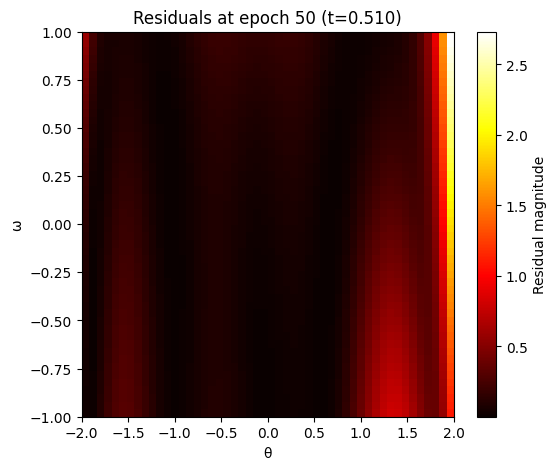

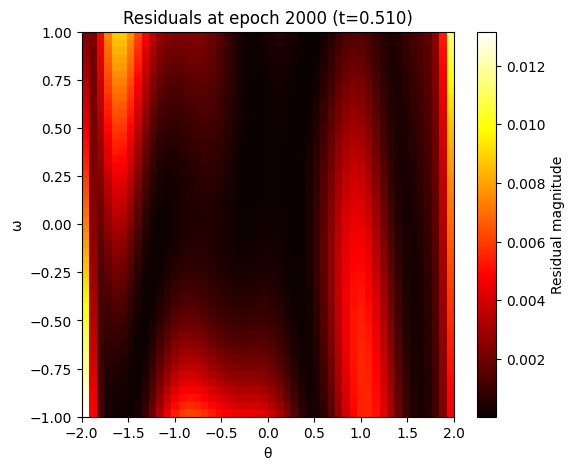

In [18]:
for epoch in [50, 2000]: #sorted(coll_snaps.keys())[:5]:
    res_file = os.path.join(snap_dir, f"residuals_{epoch}.npy")
    residuals = np.load(res_file)
    plot_residual_heatmap(residuals, title=f"Residuals at epoch {epoch}", 
                          unique_t=unique_t, 
                          t_vals=t_vals, theta=theta, 
                          omega=omega, unique_theta=unique_theta,
                          unique_omega=unique_omega)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# -----------------------------------------------------------
# 1. Style preset for paper-ready figures (matches heatmap style)
# -----------------------------------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 13,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.dpi": 150,
    "axes.linewidth": 1.2,
    "axes.grid": False,
    "savefig.bbox": "tight",
})

# consistent colormap
RESIDUAL_CMAP = "mako"   # same family as earlier heatmaps
import seaborn as sns
RESIDUAL_CMAP = sns.color_palette("mako", as_cmap=True)


# -----------------------------------------------------------
# 2. Dual heatmap plotting function (clean, compact, paper-ready)
# -----------------------------------------------------------
def plot_residual_heatmaps_dual(
        residuals_list, x_eval, ds,
        epoch_labels=None, t_slice=None,
        cmap=RESIDUAL_CMAP):

    n_plots = len(residuals_list)
    epoch_labels = epoch_labels or [f"Epoch {i}" for i in range(n_plots)]

    # ----  Extract grid coordinates (de-normalized)
    x_eval_plot = ds.detransform_input(x_eval.detach()).detach().cpu().numpy()
    theta, omega, time = x_eval_plot[:, 1], x_eval_plot[:, 2], x_eval_plot[:, 0]

    if t_slice is None:
        t_slice = float(np.min(time))

    mask = np.isclose(time, t_slice)
    theta_t, omega_t = theta[mask], omega[mask]

    n_theta = len(np.unique(theta_t))
    n_omega = len(np.unique(omega_t))
    extent = [theta_t.min(), theta_t.max(), omega_t.min(), omega_t.max()]

    # ---- Build residual grids & global color scale
    grids, vmin, vmax = [], np.inf, -np.inf
    for res in residuals_list:
        r = res[mask]
        if r.size != n_theta * n_omega:
            side = int(np.sqrt(r.size))
            n_theta = n_omega = side
        grid = r.reshape(n_omega, n_theta)
        grids.append(grid)
        vmin = min(vmin, np.nanmin(grid))
        vmax = max(vmax, np.nanmax(grid))

    # ---- Create figure
    fig, axes = plt.subplots(
        1, n_plots, figsize=(5.2 * n_plots, 4.8),
        constrained_layout=False
    )
    if n_plots == 1:
        axes = [axes]

    # ---- Plot & adjust labels
    for i, (ax, grid, label) in enumerate(zip(axes, grids, epoch_labels)):
        im = ax.imshow(
            grid, extent=extent, origin="lower", aspect="auto",
            cmap=cmap, norm=LogNorm(vmin=max(vmin, 1e-12), vmax=vmax)
        )


In [99]:
RESIDUAL_CMAP = sns.color_palette("mako", as_cmap=True)

plt.rcParams.update({
    "font.size": 14,        # base font
    "axes.titlesize": 16,   # subplot titles
    "axes.labelsize": 15,   # axis labels
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "figure.titlesize": 18,
})

def plot_residual_heatmaps_dual(
        residuals_list, x_eval, ds,
        epoch_labels=None, t_slice=None,
        cmap=RESIDUAL_CMAP):

    n_plots = len(residuals_list)
    epoch_labels = epoch_labels or [f"Epoch {i}" for i in range(n_plots)]

    # ----  Extract grid coordinates (de-normalized)
    x_eval_plot = ds.detransform_input(x_eval.detach()).detach().cpu().numpy()
    theta, omega, time = x_eval_plot[:, 1], x_eval_plot[:, 2], x_eval_plot[:, 0]

    if t_slice is None:
        t_slice = float(np.min(time))

    mask = np.isclose(time, t_slice)
    theta_t, omega_t = theta[mask], omega[mask]

    n_theta = len(np.unique(theta_t))
    n_omega = len(np.unique(omega_t))
    extent = [theta_t.min(), theta_t.max(), omega_t.min(), omega_t.max()]

    # ---- Build residual grids & scales
    grids, vmin, vmax = [], np.inf, -np.inf
    for res in residuals_list:
        r = res[mask]
        if r.size != n_theta * n_omega:
            side = int(np.sqrt(r.size))
            n_theta = n_omega = side
        grid = r.reshape(n_omega, n_theta)
        grids.append(grid)
        vmin = min(vmin, np.nanmin(grid))
        vmax = max(vmax, np.nanmax(grid))

    # ---- Figure
    fig, axes = plt.subplots(
        1, n_plots, figsize=(5.2 * n_plots, 4.8),
        constrained_layout=False
    )
    if n_plots == 1:
        axes = [axes]

    # ---- Plot & adjust labels
    for i, (ax, grid, label) in enumerate(zip(axes, grids, epoch_labels)):
        im = ax.imshow(
            grid,
            extent=extent, origin="lower", aspect="auto",
            cmap=cmap, norm=LogNorm(vmin=max(vmin, 1e-12), vmax=vmax)
        )

        ax.set_xlabel(r"$\theta$ [rad]")

        if i == 0:
            # left plot keeps full labels + title
            ax.set_ylabel(r"$\omega$ [p.u.]")
            ax.set_title(label)
        else:
            # right plot keeps ticks, loses only y-label
            ax.set_ylabel("")  
            ax.set_title(label)
            # KEEP ticks → remove this:
            # ax.tick_params(labelleft=False)
            # (we do nothing here)

    # ---- Shared colorbar
    fig.subplots_adjust(right=0.87, wspace=0.20)
    cbar_ax = fig.add_axes([0.89, 0.14, 0.025, 0.73])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label("Residual magnitude")


    plt.show()

In [100]:
res_file_50 = os.path.join(snap_dir, f"residuals_200.npy")
res_file_2000 = os.path.join(snap_dir, f"residuals_2000.npy")
residuals_50 = np.load(res_file_50)
residuals_2000 = np.load(res_file_2000)

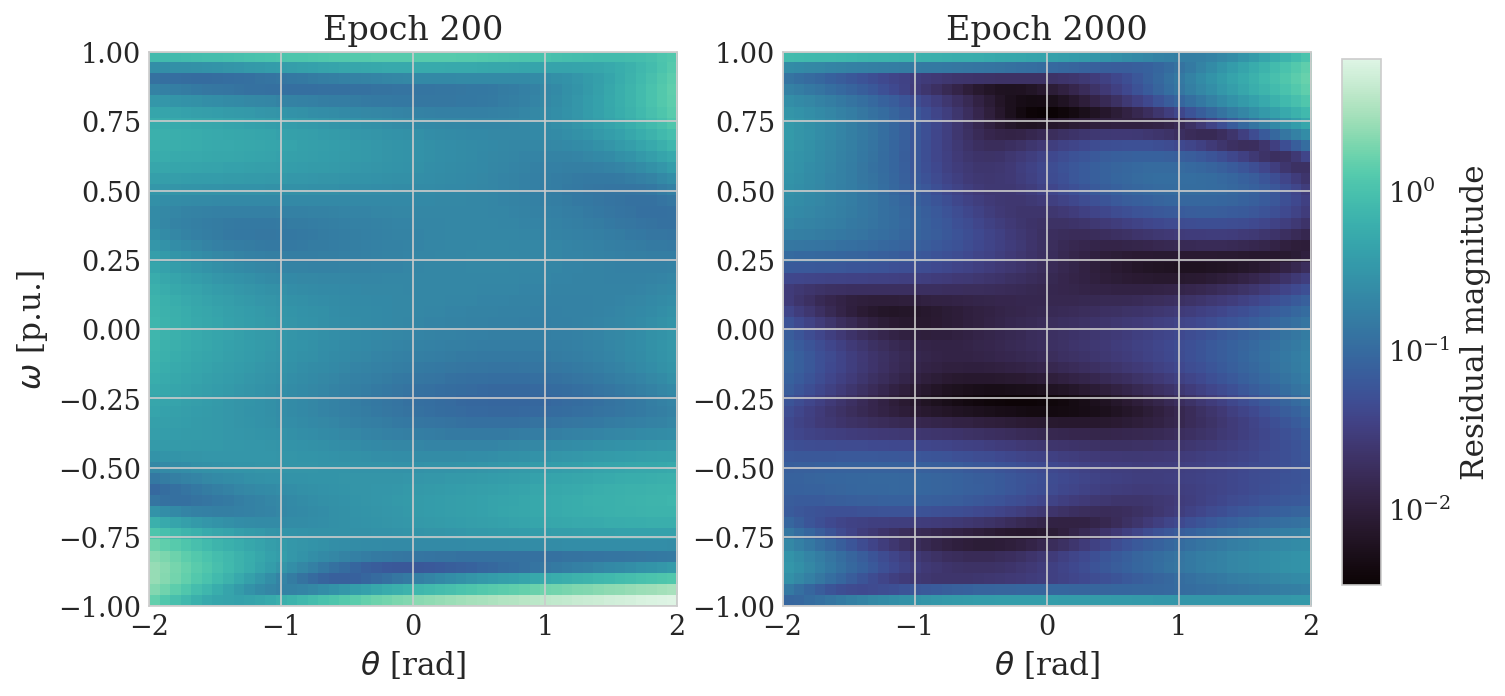

In [101]:
plot_residual_heatmaps_dual([residuals_50, residuals_2000], x_eval, ds,
                            epoch_labels=["Epoch 200", "Epoch 2000"],
                            #t_slice=unique_t[len(unique_t)//2]
                            )

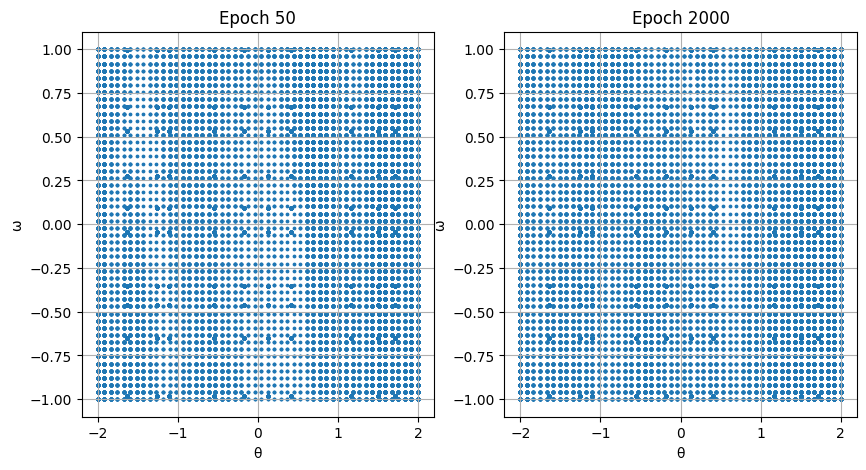

In [61]:
epochs = sorted(coll_snaps.keys())  # first two snapshots
pts1 = ds.detransform_input(coll_snaps[200]).detach().cpu().numpy()
pts2 = ds.detransform_input(coll_snaps[250]).detach().cpu().numpy()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(pts1[:,1], pts1[:,2], s=3)
plt.title(f"Epoch {epochs[0]}")
plt.xlabel("θ"); plt.ylabel("ω"); plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(pts2[:,1], pts2[:,2], s=3)
plt.title(f"Epoch {epochs[-1]}")
plt.xlabel("θ"); plt.ylabel("ω"); plt.grid(True)
plt.show()

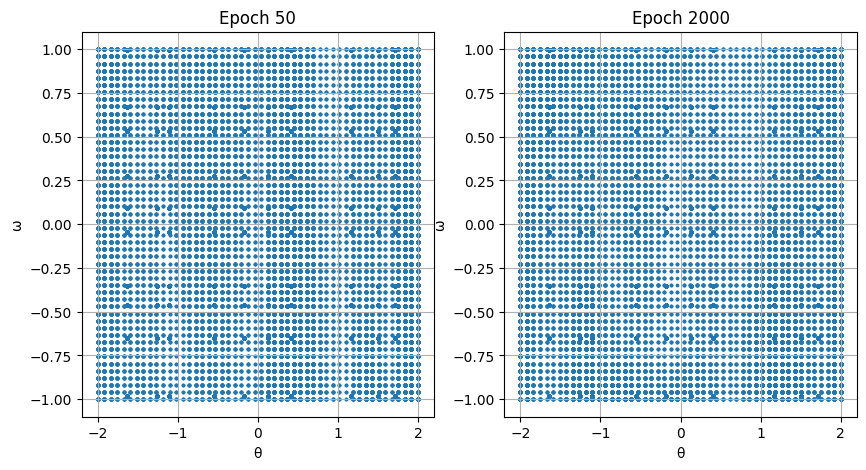

In [37]:
epochs = sorted(coll_snaps.keys())  # first two snapshots
pts1 = ds.detransform_input(coll_snaps[epochs[0]]).detach().cpu().numpy()
pts2 = ds.detransform_input(coll_snaps[epochs[-1]]).detach().cpu().numpy()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(pts1[:,1], pts1[:,2], s=3)
plt.title(f"Epoch {epochs[0]}")
plt.xlabel("θ"); plt.ylabel("ω"); plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(pts2[:,1], pts2[:,2], s=3)
plt.title(f"Epoch {epochs[-1]}")
plt.xlabel("θ"); plt.ylabel("ω"); plt.grid(True)
plt.show()

compare validation losses

In [46]:
import pandas as pd
df_online = pd.read_csv("results/3_collocation/training_log_collocation.csv")
df_baseline = pd.read_csv("results/2_weighting/training_log_Static.csv")

print("Validation Loss Comparison:")
print("Online Adaptive Collocation:", df_online["val_total"].min())
print("Baseline Static Weighting:", df_baseline["val_total"].min())
print("Difference:", df_baseline["val_total"].min() - df_online["val_total"].min())
print("Difference in percent:", 100 * (df_baseline["val_total"].min() - df_online["val_total"].min()) / df_baseline["val_total"].min())

Validation Loss Comparison:
Online Adaptive Collocation: 0.0022871374903843
Baseline Static Weighting: 0.0025307884793619
Difference: 0.0002436509889776001
Difference in percent: 9.627473452029978


In [54]:
df_online.columns

Index(['epoch', 'train_total', 'train_data', 'train_dt', 'train_pinn',
       'train_pinn_ic', 'd_data', 'd_dt_norm', 'd_pinn_norm', 'd_ic',
       'val_total', 'val_data', 'val_dt', 'weight_data', 'weight_dt',
       'weight_pinn', 'weight_pinn_ic', 'elapsed_s'],
      dtype='object')

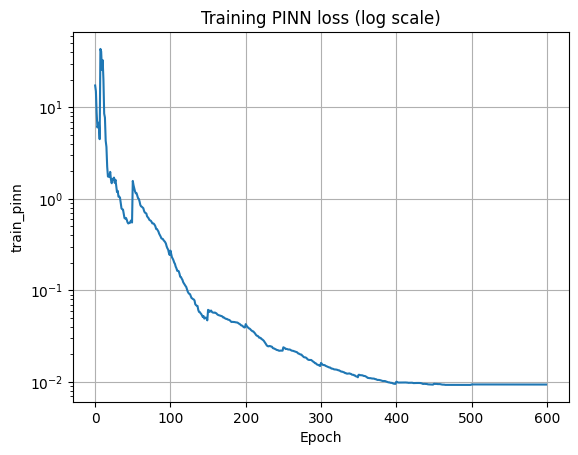

In [52]:
# plot training PINN loss on logarithmic y-axis
ax = df_online["train_pinn"].iloc[:600].plot(logy=True)
ax.set_xlabel("Epoch")
ax.set_ylabel("train_pinn")
ax.set_title("Training PINN loss (log scale)")
ax.grid(True)

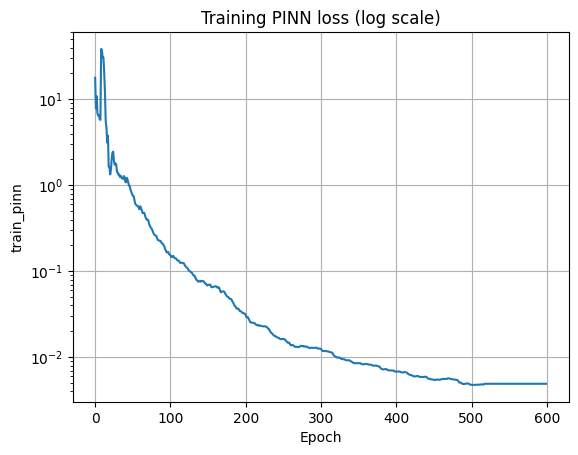

In [53]:
# plot training PINN loss on logarithmic y-axis
ax = df_baseline["train_pinn"].iloc[:600].plot(logy=True)
ax.set_xlabel("Epoch")
ax.set_ylabel("train_pinn")
ax.set_title("Training PINN loss (log scale)")
ax.grid(True)

In [55]:
import pandas as pd

# Load logs
df_online = pd.read_csv("results/3_collocation/training_log_collocation.csv")
df_baseline = pd.read_csv("results/2_weighting/training_log_Static.csv")

# Validation metrics to compare
val_metrics = ["val_total", "val_data", "val_dt", "val_pinn", "train_pinn_ic"]

# NOTE:
# Some logs use "train_pinn_ic" instead of "val_pinn_ic".
# If you also have "val_pinn_ic", replace accordingly.

results = []

for m in ["val_total", "val_data", "val_dt", "val_pinn", "val_pinn_ic"]:
    if m not in df_online.columns or m not in df_baseline.columns:
        continue

    base_min = df_baseline[m].min()
    online_min = df_online[m].min()

    abs_diff = base_min - online_min
    perc_diff = 100 * abs_diff / base_min if base_min != 0 else float("nan")

    results.append({
        "Metric": m,
        "Baseline (min)": base_min,
        "Online (min)": online_min,
        "Abs. Improvement": abs_diff,
        "% Improvement": perc_diff
    })

results_df = pd.DataFrame(results)

display(results_df)

# Optional: Export LaTeX table for the report
latex_table = results_df.to_latex(
    float_format="%.3e",
    index=False,
    caption="Comparison of validation loss components: static vs. online collocation.",
    label="tab:collocation_losses"
)
print("\nLaTeX table:\n")
print(latex_table)


=== Validation Loss Comparison Table ===


,Metric,Baseline (min),Online (min),Abs. Improvement,% Improvement
0,val_total,0.002531,0.002287,2.436510e-04,9.627473
1,val_data,0.000005,0.000005,8.825327e-08,1.633761
2,val_dt,0.002525,0.002282,2.435627e-04,9.644572



LaTeX table:

\begin{table}
\caption{Comparison of validation loss components: static vs. online collocation.}
\label{tab:collocation_losses}
\begin{tabular}{lrrrr}
\toprule
Metric & Baseline (min) & Online (min) & Abs. Improvement & % Improvement \\
\midrule
val_total & 2.531e-03 & 2.287e-03 & 2.437e-04 & 9.627e+00 \\
val_data & 5.402e-06 & 5.314e-06 & 8.825e-08 & 1.634e+00 \\
val_dt & 2.525e-03 & 2.282e-03 & 2.436e-04 & 9.645e+00 \\
\bottomrule
\end{tabular}
\end{table}

